# Load a Model

In [1]:
MODEL = "GIN"
DATASET = "BA_2grid"

# import the model
from models.models_BA_2grid import GIN_framework as framework
# import the dataset
from Datasets.synthetics import BA_2grid
from torch_geometric.loader import DataLoader
import torch.nn.functional as F
import torch
import random
import numpy as np
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt
from torch_geometric.nn import MLP, GINConv
from torch.nn import Linear

In [2]:
def set_seed(seed):
    if seed == -1:
        seed = random.randint(0, 1000)
    # Pandas also uses np random state by default
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)

    # if you are using GPU
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.enabled = False
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

In [3]:
set_seed(1)

In [4]:
# inizialize the framework
dataset = BA_2grid()
gnn = framework(dataset,device="cpu")

/home/mara/anaconda3/lib/python3.9/site-packages/torch_geometric/data/in_memory_dataset.py:157: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  warnings.warn(msg)


In [5]:
#now that the model is instaziated, we have to load the weights
gnn.load_model("models/"+DATASET+"_"+MODEL)
print("we loaded the weights")

# right now the model has trained weights.
print(gnn.model.mlp1.weight[0])

we loaded the weights
tensor([-0.1223,  0.3137,  0.0286, -0.1346,  0.3280,  0.3423, -0.0706,  0.1529,
         0.1649, -0.0715], dtype=torch.float64, grad_fn=<SelectBackward0>)


In [5]:
gnn.evaluate()

Test Loss: 0.175, Train Acc: 0.500 Test Acc: 0.500


In [6]:
def eval_probe(probe, val_dataloader):
    probe.eval()
    ys_pred = np.zeros(len(val_dataloader.dataset))
    ys_true = np.zeros(len(val_dataloader.dataset))

    i = 0
    for inputs, labels in val_dataloader:
        output = probe(inputs)
        preds = torch.argmax(output, dim=-1)
        ys_pred[i : i + len(labels)] = preds.detach().int().numpy()
        ys_true[i : i + len(labels)] = labels.int().numpy()

        i += len(labels)
    return {
            "pred": ys_pred,
            "true": ys_true,
            "accuracy": accuracy_score(ys_true, ys_pred),
            "f1_macro": f1_score(ys_true, ys_pred, average="macro"),
            "confusion_matrix": confusion_matrix(ys_true, ys_pred, normalize='true')
}

In [7]:
def train_per_layer(gnn, layer_index):
    gnn.model.train()
    gnn.optimizer.zero_grad()
    
    total_loss = 0

    for data in gnn.train_loader:

        data = data.to(gnn.device)
        gnn.optimizer.zero_grad()
        
        # Forward pass
        output = gnn.model(data.x, data.edge_index, data.batch)
        
        # Compute loss and perform backpropagation
        loss = F.nll_loss(output, data.y)
        loss.backward()
        
        # Freeze parameters of layers before the specified layer index
        i = 0
        for name, param in gnn.model.named_parameters():
            if i == layer_index:
                break
            param.requires_grad = False
            i += 1
        
        # Update parameters of the specified layer and subsequent layers
        gnn.optimizer.step()
        
        # Unfreeze all parameters for the next iteration
        for param in gnn.model.parameters():
            param.requires_grad = True
        
        total_loss += float(loss) * data.num_graphs
    return total_loss / len(gnn.train_loader.dataset)


In [8]:
def iterate_per_layer(gnn, layer_idx, num_epochs=10):
    train = 0
    for epoch in range(num_epochs):
        loss = train_per_layer(gnn, layer_idx)
        train_acc,train_loss = gnn.test(gnn.train_loader)
        train += train_acc
    test_acc,test_loss = gnn.test(gnn.test_loader)
    print(f'Layer: {layer_idx}, Epoch: {epoch:03d}, '
            f'Test Loss: {test_loss:.3f}, Train Acc: {train/num_epochs:.3f} '
            f'Test Acc: {test_acc:.3f}')
    return test_acc, test_loss

In [9]:
num_layers = 6

In [10]:
accuracies = []
losses = []
for layer in range(num_layers):
    print('Layer ' + str(layer) + ':')
    probe = framework(dataset,device="cpu")
    acc, loss = iterate_per_layer(probe, layer)
    accuracies.append(acc)
    losses.append(loss)

Layer 0:


/home/mara/anaconda3/lib/python3.9/site-packages/torch_geometric/data/in_memory_dataset.py:157: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  warnings.warn(msg)


Layer: 0, Epoch: 009, Test Loss: 0.081, Train Acc: 0.822 Test Acc: 0.905
Layer 1:


/home/mara/anaconda3/lib/python3.9/site-packages/torch_geometric/data/in_memory_dataset.py:157: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  warnings.warn(msg)


Layer: 1, Epoch: 009, Test Loss: 0.105, Train Acc: 0.823 Test Acc: 0.850
Layer 2:


/home/mara/anaconda3/lib/python3.9/site-packages/torch_geometric/data/in_memory_dataset.py:157: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  warnings.warn(msg)


Layer: 2, Epoch: 009, Test Loss: 0.153, Train Acc: 0.577 Test Acc: 0.660
Layer 3:


/home/mara/anaconda3/lib/python3.9/site-packages/torch_geometric/data/in_memory_dataset.py:157: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  warnings.warn(msg)


Layer: 3, Epoch: 009, Test Loss: 0.086, Train Acc: 0.783 Test Acc: 0.890
Layer 4:


/home/mara/anaconda3/lib/python3.9/site-packages/torch_geometric/data/in_memory_dataset.py:157: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  warnings.warn(msg)


Layer: 4, Epoch: 009, Test Loss: 0.075, Train Acc: 0.880 Test Acc: 0.915
Layer 5:


/home/mara/anaconda3/lib/python3.9/site-packages/torch_geometric/data/in_memory_dataset.py:157: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  warnings.warn(msg)


Layer: 5, Epoch: 009, Test Loss: 0.102, Train Acc: 0.751 Test Acc: 0.855


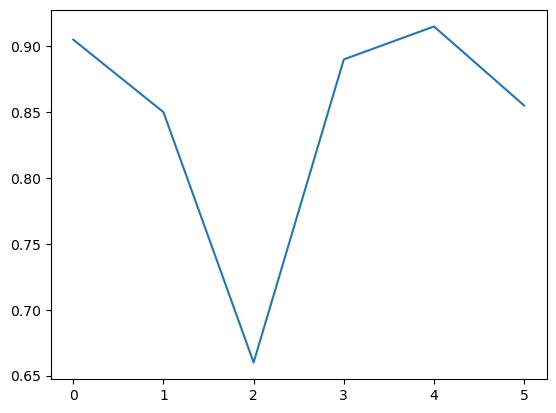

In [11]:
layers = [i for i in range(num_layers)]
plt.plot(layers, accuracies)

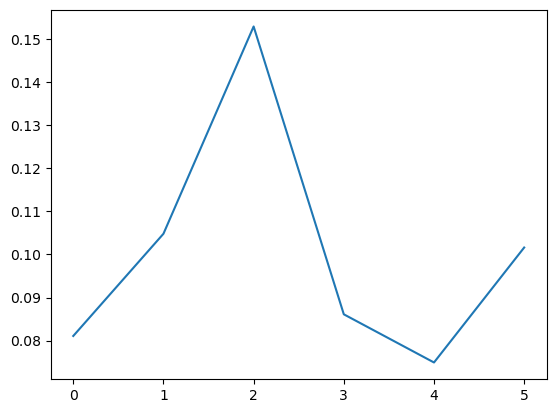

In [12]:
layers = [i for i in range(num_layers)]
plt.plot(layers, losses)